In [1]:
import torch
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

import os
from itertools import chain, islice

In [3]:
import pyvista

In [4]:
sp = torch.nn.functional.softplus
relu = torch.nn.functional.relu


In [5]:
x = torch.randn((1000,100))

In [6]:
x_gpu = x.cuda()

In [7]:
%timeit y1 = sp(x)

86.4 µs ± 5.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%timeit y2 = F.relu(x)

8.18 µs ± 842 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%timeit y3 = F.tanh(x)

/home/nils/miniconda3/envs/ma_gnn_test/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


62.8 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%timeit y4 = F.sigmoid(x)

/home/nils/miniconda3/envs/ma_gnn_test/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


30.7 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%timeit y5 = torch.tanh(x)

60.4 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%timeit y5 = torch.tanh(x_gpu)

9.32 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
y5 = torch.tanh(x)
#plt.hist(y5.reshape(-1), bins=100)

In [14]:
data_dir = "../Data/Inc_Inviscid_Hydrofoil"

In [15]:
mesh_filename = "mesh_NACA0012_5deg_6814.su2"
#mesh = pyvista.read_meshio(os.path.join(data_dir, mesh_filename))

In [16]:
3558*3

10674

In [17]:
result_filename = "flow.vtu"
flow = pyvista.read(os.path.join(data_dir, result_filename))

In [18]:
pd = flow.GetPointData()
ida=pd.GetGlobalIds()
type(ida)

NoneType

In [19]:
flow.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : None
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    Pressure                float32  (3559,)
    Velocity                float32  (3559, 3)
    Pressure_Coefficient    float32  (3559,)
    Density                 float32  (3559,)

In [20]:
from meshio._common import _pick_first_int_data, warn
from meshio._exceptions import ReadError
from meshio._files import open_file
from meshio._helpers import register_format
from meshio._mesh import CellBlock, Mesh

su2_type_to_numnodes = {
    3: 2,  # line
    5: 3,  # triangle
    9: 4,  # quad
    10: 4,  # tetra
    12: 8,  # hexahedron
    13: 6,  # wedge
    14: 5,  # pyramid
}
su2_to_meshio_type = {
    3: "line",
    5: "triangle",
    9: "quad",
    10: "tetra",
    12: "hexahedron",
    13: "wedge",
    14: "pyramid",
}
meshio_to_su2_type = {
    "line": 3,
    "triangle": 5,
    "quad": 9,
    "tetra": 10,
    "hexahedron": 12,
    "wedge": 13,
    "pyramid": 14,
}

def read_su2_mesh(filename):

    with open_file(filename, "r") as f:
        mesh = read_su2_mesh_buffer(f)
    return mesh

def read_su2_mesh_buffer(f):
    cells = []
    cell_data = {"su2:tag": []}

    point_data = {"PointID": []}

    itype = "i8"
    ftype = "f8"
    ftype = "double"
    dim = 0

    next_tag_id = 0
    expected_nmarkers = 0
    markers_found = 0
    while True:
        line = f.readline()
        if not line:
            # EOF
            break

        line = line.strip()
        if len(line) == 0:
            continue
        if line[0] == "%":
            continue

        try:
            name, rest_of_line = line.split("=")
        except ValueError:
            print(f"meshio could not parse line\n {line}\n skipping.....")
            continue

        if name == "NDIME":
            dim = int(rest_of_line)
            if dim != 2 and dim != 3:
                raise ValueError(f"Invalid dimension value {line}")

        elif name == "NPOIN":
            # according to documentation rest_of_line should just be a int,
            # and the next block should be just the coordinates of the points
            # However, some file have one or two extra indices not related to the
            # actual coordinates.
            # So lets read the next line to find its actual number of columns
            #
            first_line = f.readline()
            first_line = first_line.split()
            # print(first_line)
            first_line = np.array(first_line, dtype=ftype)
            # print(first_line)

            extra_columns = first_line.shape[0] - dim

            num_verts = int(rest_of_line.split()[0]) - 1
            # print(num_verts, num_verts * (dim + extra_columns))
            # # points = np.fromfile(
            # #     f, count=num_verts * (dim + extra_columns), dtype=ftype, sep=" "
            # # )
            # points = np.fromfile(f, count=10671, sep=" ")
            # print(points[:150].reshape(-1, 3))
            # print(points[-9:].reshape(-1, 3))
            # print(points.shape)
            
            #return points

            point_lines = ""
            for i in range(num_verts):
                point_lines += f.readline()
            
            points = np.fromstring(point_lines, dtype=ftype, sep=" ")            


            points = points.reshape(num_verts, dim + extra_columns)

            # # save off any extra info
            # if extra_columns > 0:
            #     first_line = first_line[:-extra_columns]
            #     points = points[:, :-extra_columns]

            # add the first line we read separately
            points = np.vstack([first_line, points])
            
            if extra_columns > 0:
                point_ids = points[:,-1].copy().astype(int)
                point_data["PointID"] = point_ids
                # for i in point_ids:
                #     point_data["PointID"].append(i)
                points = points[:, :-extra_columns]

        elif name == "NELEM" or name == "MARKER_ELEMS":
            # we cannot? read at once using numpy because we do not know the
            # total size. Read, instead next num_elems as is and re-use the
            # translate_cells function from vtk reader

            num_elems = int(rest_of_line)
            gen = islice(f, num_elems)

            # some files has an extra int column while other not
            # We do not need it so make sure we will skip it
            first_line_str = next(gen)
            first_line = first_line_str.split()
            nnodes = su2_type_to_numnodes[int(first_line[0])]
            has_extra_column = False
            if nnodes + 1 == len(first_line):
                has_extra_column = False
            elif nnodes + 2 == len(first_line):
                has_extra_column = True
            else:
                raise ReadError(f"Invalid number of columns for {name} field")

            # reset generator
            gen = chain([first_line_str], gen)

            cell_array = " ".join([line.rstrip("\n") for line in gen])
            cell_array = np.fromiter(cell_array.split(), dtype=itype)

            # print("cell_array:", cell_array)

            cells_, _ = _translate_cells(cell_array, has_extra_column)

            # print("cells:", cells_)

            for eltype, data in cells_.items():
                cells.append(CellBlock(eltype, data))
                num_block_elems = len(data)
                if name == "NELEM":
                    cell_data["su2:tag"].append(
                        np.full(num_block_elems, 0, dtype=np.int32)
                    )
                else:
                    tags = np.full(num_block_elems, next_tag_id, dtype=np.int32)
                    cell_data["su2:tag"].append(tags)

        elif name == "NMARK":
            expected_nmarkers = int(rest_of_line)
        elif name == "MARKER_TAG":
            next_tag = rest_of_line
            try:
                next_tag_id = int(next_tag)
            except ValueError:
                next_tag_id += 1
                warn(
                    "meshio does not support tags of string type.\n"
                    f"    Surface tag {rest_of_line} will be replaced by {next_tag_id}"
                )
            markers_found += 1

    if markers_found != expected_nmarkers:
        warn(
            f"expected {expected_nmarkers} markers according to NMARK value "
            f"but found only {markers_found}"
        )

    # merge boundary elements in a single cellblock per cell type
    if dim == 2:
        types = ["line"]
    else:
        types = ["triangle", "quad"]

    indices_to_merge = {}
    for t in types:
        indices_to_merge[t] = []

    for index, cell_block in enumerate(cells):
        if cell_block.type in types:
            indices_to_merge[cell_block.type].append(index)

    cdata = cell_data["su2:tag"]
    for type, indices in indices_to_merge.items():
        if len(indices) > 1:
            cells[indices[0]] = CellBlock(
                type, np.concatenate([cells[i].data for i in indices])
            )
            cdata[indices[0]] = np.concatenate([cdata[i] for i in indices])

    # delete merged blocks
    idelete = []
    for type, indices in indices_to_merge.items():
        idelete += indices[1:]

    for i in sorted(idelete, reverse=True):
        del cells[i]
        del cdata[i]

    cell_data["su2:tag"] = cdata
    return Mesh(points, cells, cell_data=cell_data, point_data=point_data)

def _translate_cells(data, has_extra_column=False):
    # adapted from _vtk.py
    # Translate input array  into the cells dictionary.
    # `data` is a one-dimensional vector with
    # (vtk cell type, p0, p1, ... ,pk, vtk cell type, p10, p11, ..., p1k, ...

    entry_offset = 1
    if has_extra_column:
        entry_offset += 1

    # Collect types into bins.
    # See <https://stackoverflow.com/q/47310359/353337> for better
    # alternatives.
    types = []
    i = 0
    while i < len(data):
        types.append(data[i])
        i += su2_type_to_numnodes[data[i]] + entry_offset

    types = np.array(types)
    bins = {u: np.where(types == u)[0] for u in np.unique(types)}

    # Deduct offsets from the cell types. This is much faster than manually
    # going through the data array. Slight disadvantage: This doesn't work for
    # cells with a custom number of points.
    numnodes = np.empty(len(types), dtype=int)
    for tpe, idx in bins.items():
        numnodes[idx] = su2_type_to_numnodes[tpe]
    offsets = np.cumsum(numnodes + entry_offset) - (numnodes + entry_offset)

    cells = {}
    cell_data = {}
    #cell_data["CellID"] = [None]*len(bins)
    cell_ids = []
    i = 0
    for tpe, b in bins.items():
        meshio_type = su2_to_meshio_type[tpe]
        nnodes = su2_type_to_numnodes[tpe]
        indices = np.add.outer(offsets[b], np.arange(1, nnodes + 1))
        # print(indices)
        # print(indices[:,-1] + 1)
        # print(indices.shape)
        cells[meshio_type] = data[indices]
        if has_extra_column:
            cell_id_indices = indices[:,-1] + 1
            #cell_data["CellID"] = cell_data["CellID"].append(data[cell_id_indices])
            #cell_data["CellID"][i] = data[cell_id_indices]
            cell_ids = data[cell_id_indices]
        else:
            #cell_data["CellID"][i] = np.empty(len(offsets), dtype=int)
            cell_ids = np.full(len(offsets), -1, dtype=int)
            pass
        i += 1
    # print(cell_ids)
    cell_data["CellID"] = cell_ids
    return cells, cell_data

mesh = read_su2_mesh(os.path.join(data_dir, mesh_filename))

Warning: meshio does not support tags of string type.
    Surface tag  airfoil will be replaced by 1

Warning: meshio does not support tags of string type.
    Surface tag  lower_wall will be replaced by 2

Warning: meshio does not support tags of string type.
    Surface tag  inlet will be replaced by 3

Warning: meshio does not support tags of string type.
    Surface tag  outlet will be replaced by 4

Warning: meshio does not support tags of string type.
    Surface tag  upper_wall will be replaced by 5

In [21]:
mesh.cell_data

{'su2:tag': [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [22]:
len(flow.cells_dict[5])

6814

In [23]:
flow.cells_dict[5]

array([[ 306,  305,  304],
       [ 128,  127,  307],
       [  40,   39,  308],
       ...,
       [ 302, 3471,  423],
       [2811, 3053, 2625],
       [2812, 2625,  237]])

In [24]:
mesh.cells_dict.keys()

dict_keys(['triangle', 'line'])

In [25]:
cb = mesh.cells[1]

In [26]:
mesh.cell_data

{'su2:tag': [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [27]:
flow.point_data.keys()

['Pressure', 'Velocity', 'Pressure_Coefficient', 'Density']

In [28]:
qoi = np.asarray(flow.point_data["Pressure_Coefficient"])
qoi.shape

(3559,)

In [29]:
qoi

array([ 0.00696905,  0.0069637 ,  0.0068815 , ..., -0.19919837,
       -0.5334331 ,  0.2650062 ], dtype=float32)

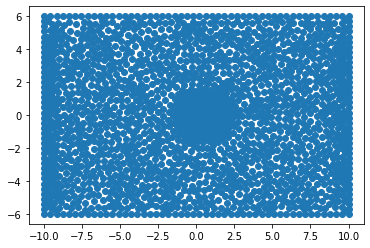

In [30]:
plt.scatter(mesh.points[:,0], mesh.points[:,1])

In [31]:
su2_tag = mesh.cell_data['su2:tag'][1]
su2_tag.shape

(304,)

In [32]:
cells_line = mesh.cells_dict["line"]
cells_line.shape

(304, 2)

In [33]:
boundary_node_indices = set()
airfoil_node_indices = set()

for i, tag in enumerate(su2_tag):
    if tag == 1:
        airfoil_node_indices.update(cells_line[i])
    if tag >= 1:
        boundary_node_indices.update(cells_line[i])

airfoil_node_indices = sorted(airfoil_node_indices)
boundary_node_indices = sorted(boundary_node_indices)
#boundary_nodes = [mesh.points[i, :2] for i in boundary_node_indices]
boundary_nodes = mesh.points[boundary_node_indices, :2]

len(boundary_nodes), boundary_nodes.shape

(304, (304, 2))

In [34]:
airfoil_node_indices

[176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303]

In [35]:
n_points = len(mesh.points)

In [36]:
bnode_indices = [
    mesh.points[boundary_node_indices, 0].argmax(), 
    mesh.points[boundary_node_indices, 0].argmin(), 
    mesh.points[boundary_node_indices, 1].argmax(), 
    mesh.points[boundary_node_indices, 1].argmin(), 
]

bnode_indices += np.random.choice(airfoil_node_indices, len(airfoil_node_indices) // 2).tolist()

In [37]:
n_points = len(mesh.points)
#bnode_indices = boundary_node_indices

nodes_lvl = [i for i in range(n_points) if not i in bnode_indices]
#nodes_lvl = [i for i in range(n_points)]
n_nodes_lvl = len(nodes_lvl)

graph_dict = {0: nodes_lvl + bnode_indices}
#graph_dict = {0: nodes_lvl}

print(0, len(graph_dict[0]), len(nodes_lvl), len(bnode_indices))

for i in range(1, 10):
    n_nodes_lvl = n_nodes_lvl // 2
    #print(i, n_nodes_lvl)
    nodes_lvl = sorted(np.random.choice(nodes_lvl, n_nodes_lvl, replace=False))
    graph_dict[i] = nodes_lvl + bnode_indices
    # graph_dict[i] = nodes_lvl
    print(i, len(graph_dict[i]), len(nodes_lvl), len(bnode_indices))

test_nodes = list(set(graph_dict[0]) - set(graph_dict[1]))

0 3569 3501 68
1 1818 1750 68
2 943 875 68
3 505 437 68
4 286 218 68
5 177 109 68
6 122 54 68
7 95 27 68
8 81 13 68
9 74 6 68


(-0.5333333333333333, 0.5333333333333333)

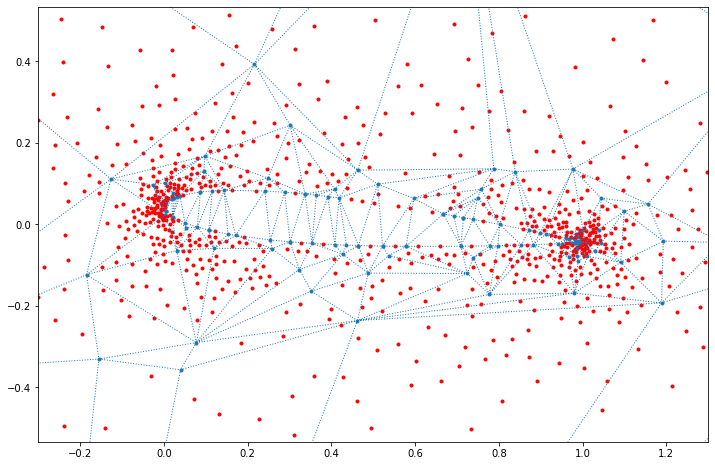

In [38]:
i = 5
nodes_lvl = graph_dict[i]

tri = Delaunay(mesh.points[nodes_lvl,:2])

fig_width = 12
fig_height = 8
center = [0.5, 0.]
data_max = [10, 6]
data_min = [-10, -6]
data_width = 20
data_hwidth = 12

zoom = 15

xmin = center[0] - data_hwidth/zoom
xmax = center[0] + data_hwidth/zoom
ymin = center[1] - data_hwidth/zoom*fig_height/fig_width
ymax = center[1] + data_hwidth/zoom*fig_height/fig_width

plt.figure(figsize=(fig_width, fig_height))
plt.scatter(mesh.points[nodes_lvl,0], mesh.points[nodes_lvl,1], marker=".")
plt.scatter(mesh.points[test_nodes,0], mesh.points[test_nodes,1], marker=".", c="red")
plt.triplot(mesh.points[nodes_lvl,0], mesh.points[nodes_lvl,1], tri.simplices, lw=1, linestyle=":")
# airfoil = np.where(su2_tag == 1)[0]
# print(airfoil)

#plt.plot(mesh.points[airfoil_node_indices][:,0], mesh.points[airfoil_node_indices][:,1], linestyle="-")
plt.xlim([-2., 3.])
plt.ylim([-1, 1])

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

In [39]:
mesh.points[airfoil_node_indices]

array([[ 1.00805930e+00, -4.44494288e-02],
       [ 1.00317187e+00, -4.33943894e-02],
       [ 9.98324424e-01, -4.23479785e-02],
       [ 9.93528303e-01, -4.12492952e-02],
       [ 9.88769172e-01, -4.01527722e-02],
       [ 9.82399052e-01, -3.87006000e-02],
       [ 9.75462184e-01, -3.71245508e-02],
       [ 9.68553499e-01, -3.55608680e-02],
       [ 9.61668954e-01, -3.40180255e-02],
       [ 9.53366399e-01, -3.21591900e-02],
       [ 9.43433836e-01, -2.99549379e-02],
       [ 9.33519939e-01, -2.77679698e-02],
       [ 9.23621617e-01, -2.56029663e-02],
       [ 9.12937388e-01, -2.32854674e-02],
       [ 8.99065798e-01, -2.02971346e-02],
       [ 8.85202913e-01, -1.73344021e-02],
       [ 8.71344260e-01, -1.44088930e-02],
       [ 8.57489644e-01, -1.15122346e-02],
       [ 8.39271057e-01, -7.75416951e-03],
       [ 8.20739129e-01, -3.96911935e-03],
       [ 8.02201698e-01, -2.30902049e-04],
       [ 7.83657015e-01,  3.46123361e-03],
       [ 7.61987501e-01,  7.71606884e-03],
       [ 7.

In [40]:
boundary_nodes

array([[-1.00000000e+01, -6.00000000e+00],
       [-1.00000000e+01, -5.69230769e+00],
       [-1.00000000e+01, -5.38461538e+00],
       [-1.00000000e+01, -5.07692308e+00],
       [-1.00000000e+01, -4.76923077e+00],
       [-1.00000000e+01, -4.46153846e+00],
       [-1.00000000e+01, -4.15384615e+00],
       [-1.00000000e+01, -3.84615385e+00],
       [-1.00000000e+01, -3.53846154e+00],
       [-1.00000000e+01, -3.23076923e+00],
       [-1.00000000e+01, -2.92307692e+00],
       [-1.00000000e+01, -2.61538462e+00],
       [-1.00000000e+01, -2.30769231e+00],
       [-1.00000000e+01, -2.00000000e+00],
       [-1.00000000e+01, -1.69230769e+00],
       [-1.00000000e+01, -1.38461538e+00],
       [-1.00000000e+01, -1.07692308e+00],
       [-1.00000000e+01, -7.69230769e-01],
       [-1.00000000e+01, -4.61538462e-01],
       [-1.00000000e+01, -1.53846154e-01],
       [-1.00000000e+01,  1.53846154e-01],
       [-1.00000000e+01,  4.61538462e-01],
       [-1.00000000e+01,  7.69230769e-01],
       [-1.